/Users/saurabh/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saurabh/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


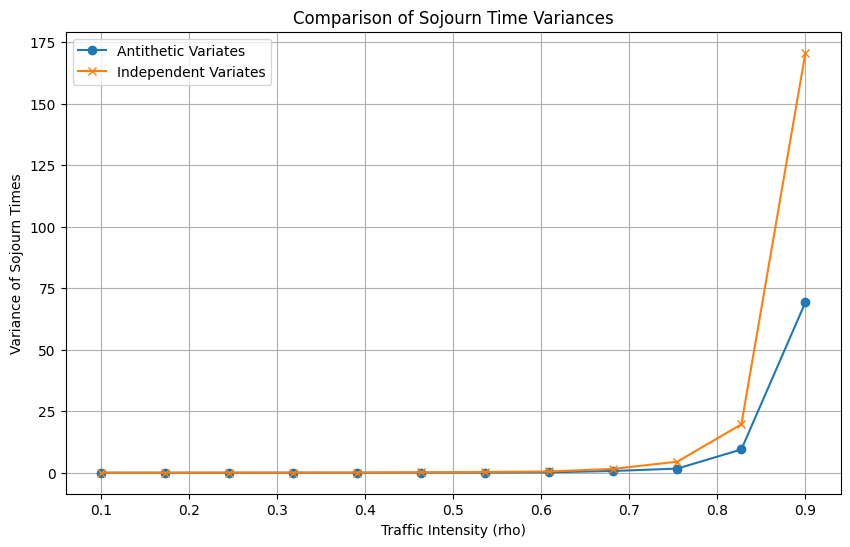

/Users/saurabh/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/saurabh/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


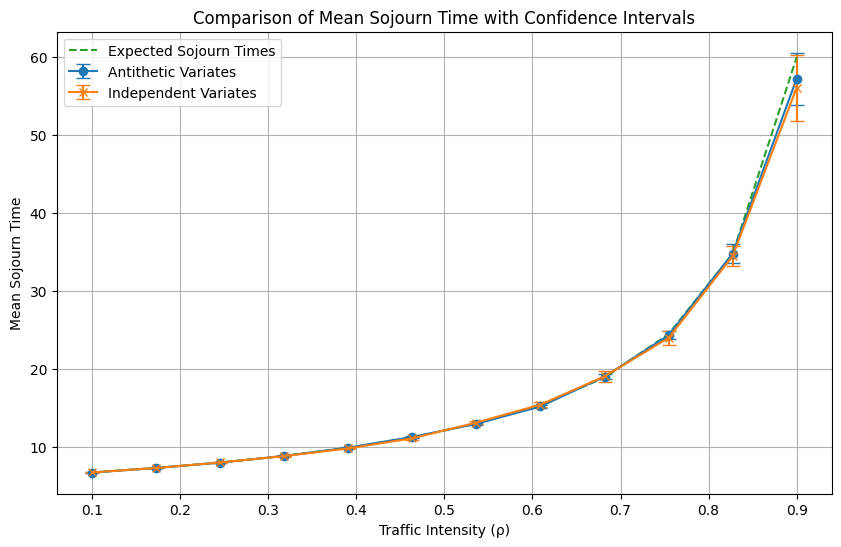

In [1]:
import heapq
import random
from math import log
import numpy as np
import matplotlib.pyplot as plt

class Expon:
    def __init__(self, xmean):
        self.mean = xmean
        self.low = 0.00000001
        self.high = 0.99999999

    def setseed(self, seed):
        random.seed(seed)

    def restore_seed(self):
        random.setstate(self.state)

    def unif(self):
        self.state = random.getstate()
        u = random.uniform(self.low, self.high)
        return u

    def c_unif(self):
        u = self.unif()
        return 1 - u

    def expon(self):
        u = self.unif()
        return -self.mean * log(1 - u)

    def expon2(self):
        u = self.c_unif()
        return -self.mean * log(1 - u)

def run_simulation(N, a_rate, s_rate,arriv,serv,complement=False):


    mean_delays = []
    means_cust = []

    for i in range(1):
        clock = 0
        next_arrival = (arriv.expon2() if complement else arriv.expon())
        queues = [[] for _ in range(N)]
        # print("queues:",queues)
        customers_in_queues = [0] * N
        total_delay = 0
        total_customers = 0
        queue_snapshots = [[] for _ in range(N)]

        next_departures = [float('inf')] * N

        arrival_times = {} 

        while total_customers < 3000:
            next_event_time = min(next_arrival, min(next_departures))
            next_event_queue = 0 if next_event_time == next_arrival else next_departures.index(next_event_time) + 1

            if next_event_queue == 0:
                clock = next_arrival
                total_customers += 1
                customers_in_queues[0] += 1
                heapq.heappush(queues[0], (clock, total_customers))
                arrival_times[total_customers] = clock  
                next_arrival += (arriv.expon2() if complement else arriv.expon())
                if customers_in_queues[0] == 1:
                    service_time = serv.expon2() if complement else serv.expon()
                    next_departures[0] = queues[0][-1][0] + service_time
            else:
                queue_index = next_event_queue - 1
                clock = next_departures[queue_index]
                # print("queue_index:",queue_index)
                # print("queue at above index:",queues[queue_index])
                _, customer_id = heapq.heappop(queues[queue_index])
                if queue_index == N - 1:  # Last queue
                    if total_customers > 800:
                        total_delay += clock - arrival_times[customer_id]  # Total delay from first to last queue
                # if total_customers > 800:
                #     queue_snapshots[queue_index].append(len(queues[queue_index]))
                customers_in_queues[queue_index] -= 1
                if customers_in_queues[queue_index] == 0:
                    next_departures[queue_index] = float('inf')
                else:
                    service_time = serv.expon2() if complement else serv.expon()
                    next_departures[queue_index] = clock + service_time
                if queue_index < N - 1:
                    customers_in_queues[queue_index + 1] += 1
                    heapq.heappush(queues[queue_index + 1], (clock, customer_id))
                    if customers_in_queues[queue_index + 1] == 1:
                        service_time = serv.expon2() if complement else serv.expon()
                        next_departures[queue_index + 1] = queues[queue_index + 1][-1][0] + service_time

        means_cust.append([np.mean(snapshot) for snapshot in queue_snapshots])
        here_mean_delay = total_delay / (total_customers - 800)
        mean_delays.append(here_mean_delay)
    return mean_delays

def simulate_tandem_queues_antithetic(N, a_rate, s_rate, arriv,serv,runs=50):
    mean_delays = []

    for _ in range(runs // 2):  # half as many because we are running pairs
        delays1 = run_simulation(N, a_rate, s_rate, arriv,serv)
        delays2= run_simulation(N, a_rate, s_rate,arriv, serv, complement=True)
        # print("delays1:",delays1)
        # print("delays2:",delays2)

        paired_delays = [(d1 + d2) / 2 for d1, d2 in zip(delays1, delays2)]
        # print("paired_delays:",paired_delays)
        mean_delays.append(sum(paired_delays) / len(paired_delays))

    return mean_delays
def calculate_expected_sojourn_time(N, a_rate, s_rate):
    if s_rate <= a_rate:
        return float('inf')  

    rho = a_rate / s_rate
    if rho >= 1:
        return float('inf')  
    
    total_expected_sojourn_time = 0
    # Sum up waiting and service times for each queue
    for i in range(N):
        # expected_service_time = 1 / s_rate
        # expected_waiting_time = rho / (s_rate * (1 - rho))
        expected_waiting_time = (s_rate / (1 - rho))

        # total_expected_sojourn_time += (expected_service_time + expected_waiting_time)
        total_expected_sojourn_time +=  expected_waiting_time 

    return total_expected_sojourn_time

def analyze_queue_system_variance(N, a_rate, s_rate, rho_values, runs_per_rho=50, customers_target=3000):
    antithetic_variances = []
    independent_variances = []

    for rho in rho_values:
        new_a_rate = a_rate * rho
        new_s_rate = s_rate
        arriv = Expon(1 / new_a_rate)
        serv = Expon(1 / new_s_rate)
        arriv.setseed(1234)
        serv.setseed(1234)
        antithetic_delays = simulate_tandem_queues_antithetic(N, new_a_rate, new_s_rate,arriv,serv, runs=runs_per_rho)
        independent_delays = []
        runs=runs_per_rho//2
        for _ in range(runs_per_rho):
            independent_delays.extend(run_simulation(N, new_a_rate, new_s_rate,arriv,serv,runs))

        # Calculate variances
        antithetic_var = np.var(antithetic_delays)
        independent_var = np.var(independent_delays)
        # print(antithetic_var)
        antithetic_variances.append(antithetic_var)
        independent_variances.append(independent_var)

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(rho_values, antithetic_variances, label='Antithetic Variates', marker='o')
    plt.plot(rho_values, independent_variances, label='Independent Variates', marker='x')
    plt.xlabel('Traffic Intensity (rho)')
    plt.ylabel('Variance of Sojourn Times')
    plt.title('Comparison of Sojourn Time Variances')
    # plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.savefig("hw4_q1_variance.pdf")
    plt.show()

    # return antithetic_variances, independent_variances

def analyze_queue_system_mean(N, a_rate, s_rate, rho_values, runs_per_rho=50, customers_target=3000):
    mean_delays_antithetic = []
    mean_delays_independent = []
    confidence_intervals_antithetic = []
    confidence_intervals_independent = []
    expected_sojourn_times = []  # You should calculate this based on your queue theory knowledge

    # arriv = Expon(scale=1 / a_rate)
    # serv = Expon(scale=1 / s_rate)
    # np.random.seed(1234)  # Ensure reproducibility

    # print("\narriv:", arriv)
    for rho in rho_values:
        # Adjust rates based on rho
        new_a_rate = a_rate * rho
        new_s_rate = s_rate
        arriv = Expon(1 / new_a_rate)
        serv = Expon(1 / new_s_rate)
        arriv.setseed(1234)
        serv.setseed(1234)
        # Run simulations with antithetic variates
        antithetic_delays = simulate_tandem_queues_antithetic(N, new_a_rate, new_s_rate,arriv,serv, runs=runs_per_rho)
        mean_delay_antithetic = np.mean(antithetic_delays)
        se_antithetic = np.std(antithetic_delays, ddof=1) / np.sqrt(len(antithetic_delays))
        ci_antithetic = 1.96 * se_antithetic

        # Run independent simulations
        independent_delays = [run_simulation(N, new_a_rate, new_s_rate, arriv, serv) for _ in range(runs_per_rho//2)]
        # print("\n independent delays:",independent_delays)
        mean_delay_independent = np.mean(independent_delays)
        se_independent = np.std(independent_delays, ddof=1) / np.sqrt(len(independent_delays))
        ci_independent = 1.96 * se_independent

        mean_delays_antithetic.append(mean_delay_antithetic)
        confidence_intervals_antithetic.append(ci_antithetic)
        mean_delays_independent.append(mean_delay_independent)
        confidence_intervals_independent.append(ci_independent)

        expected_sojourn_times.append(calculate_expected_sojourn_time(N, new_a_rate, new_s_rate))  # Implement this based on queue theory


    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.errorbar(rho_values, mean_delays_antithetic, yerr=confidence_intervals_antithetic, label='Antithetic Variates', fmt='-o', capsize=5)
    plt.errorbar(rho_values, mean_delays_independent, yerr=confidence_intervals_independent, label='Independent Variates', fmt='-x', capsize=5)
    plt.plot(rho_values, expected_sojourn_times, label='Expected Sojourn Times', linestyle='--')

    plt.xlabel('Traffic Intensity (ρ)')
    plt.ylabel('Mean Sojourn Time')
    plt.title('Comparison of Mean Sojourn Time with Confidence Intervals')
    plt.legend()
    # plt.yscale("log")
    plt.grid(True)
    plt.savefig("hw4_q1_delays.pdf")
    plt.show()


rho_values = np.linspace(0.1, 0.9, 12)

analyze_queue_system_variance(6, 1.0, 1.0, rho_values)
analyze_queue_system_mean(6, 1.0, 1.0, rho_values)
